In [38]:
# 验证路径设置
import os
import sys
import pandas as pd
import numpy as np

# 自动计算项目根目录
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, "..", ".."))  
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
# 打印当前环境路径
print(f"Python executable: {sys.executable}")
print(f"Project root: {project_root}")
# 导入模块
try:
    from config.tickers import NASDAQ_100
    from config.NASDAQ_100_Chinese  import NASDAQ_100_Chinese
    from importnb import Notebook
    from openai import OpenAI 
    from sklearn.model_selection import train_test_split
    with Notebook():
        from src.visualization import plot_technical
        from src.downloader import download_stock_data
    print("✅ 模块导入成功！")
except ImportError as e:
    print(f"❌ 导入失败: {str(e)}")
    print("当前 Python 路径：", sys.path)


Python executable: c:\Users\theli\Documents\GitHub\stock_project\.venv\Scripts\python.exe
Project root: c:\Users\theli\Documents\GitHub\stock_project
✅ 模块导入成功！


In [39]:
# 下载股票数据
start_date = '2024-01-01'
end_date = '2025-04-01'
period = '1y'
ticker = ['IREN']

df = download_stock_data( ticker , start_date , end_date , period=period)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume,Daily Return,Log Return,Range Pct,MA10,MA50,Volatility,RSI
Datetime,,,,,,,,,,,,
2025-08-12 13:30:00+00:00,17.969999,18.594999,17.712299,18.309999,0,NaN,NaN,4.983543,NaN,NaN,NaN,NaN
2025-08-12 14:30:00+00:00,18.315001,18.400000,18.090000,18.135000,1404537,-0.955758,-0.009604,1.713651,NaN,NaN,NaN,NaN
2025-08-12 15:30:00+00:00,18.135000,18.254999,17.980000,18.075001,1429730,-0.330849,-0.003314,1.529475,NaN,NaN,NaN,NaN
2025-08-12 16:30:00+00:00,18.080000,18.200001,17.969999,18.040001,1296074,-0.193637,-0.001938,1.279919,NaN,NaN,NaN,NaN
2025-08-12 17:30:00+00:00,18.037201,18.110001,17.834999,17.915001,1150613,-0.692905,-0.006953,1.541921,NaN,NaN,NaN,NaN


In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [41]:
# 特征工程：创建滞后特征
cols = []
for lag in [1, 2, 4, 6, 8]:
    cols.append(f'Close_lag_{lag}')
    df[f'Close_lag_{lag}'] = df['Close'].shift(lag)


In [42]:
# 添加变量技术指标
df['price_change'] = np.where(
    df['Close']>df['Close'].shift(1), 1, 
    np.where(df['Close']<df['Close'].shift(1), -1, 0)
)
df['hour_volatility'] = (df['High'] - df['Low'])/df['Close']
df['Volatility_trend'] = df['hour_volatility'].rolling(window=4).mean()

In [43]:
# 清理缺失值并准备数据
df_clean = df.dropna()
X = df_clean[cols + ['MA50', 'RSI', 'price_change', 'hour_volatility', 'Volatility_trend']]
y = df_clean['Close']

In [44]:
# 训练测试分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [45]:
# 训练模型
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=8,
    min_samples_leaf=5,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [46]:
# 评估
print(f"Test R^2: {model.score(X_test, y_test)}")

Test R^2: 0.9893114344243575


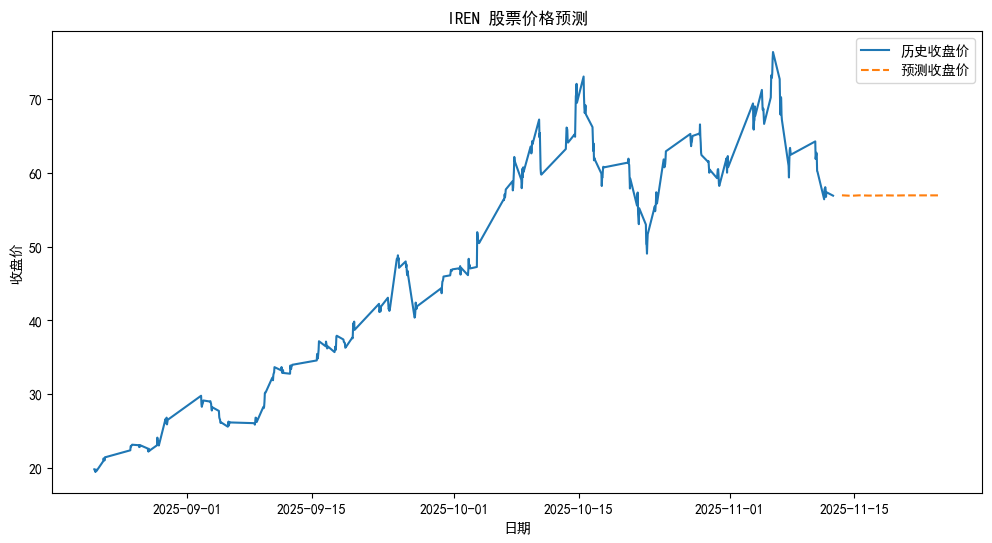

In [47]:
# 预测
predict_steps = 12 # depending on your interval
window_size = 48
predictions = []
latest_time_window = df_clean[['Close', 'MA50', 'RSI', 'price_change', 'hour_volatility', 'Volatility_trend']].iloc[-window_size:].copy()

for _ in range(predict_steps):
    lags = []
    for lag in cols:
        lags.append(latest_time_window['Close'].iloc[-int(lag.split('_')[-1])])
    
    input_features = pd.DataFrame(
        [lags+[latest_time_window['MA50'].iloc[-1], 
               latest_time_window['RSI'].iloc[-1],
                latest_time_window['price_change'].iloc[-1],
                latest_time_window['hour_volatility'].iloc[-1],
                latest_time_window['Volatility_trend'].iloc[-1]
               ]
        ],
        columns=cols + ['MA50', 'RSI', 'price_change', 'hour_volatility', 'Volatility_trend']
    )
    next_pred = model.predict(input_features)[0]
    predictions.append(next_pred)
    
    new_row = {
        'Close': next_pred,
        'MA50': latest_time_window['MA50'].iloc[-1],  # Placeholder
        'RSI': latest_time_window['RSI'].iloc[-1]     # Placeholder
    }
    # DataFrame.append was removed in newer pandas; use pd.concat instead
    latest_time_window = pd.concat([latest_time_window, pd.DataFrame([new_row])], ignore_index=True)

# print("未来预测值：", predictions)

# 可视化结果
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # For Chinese on Windows
plt.rcParams['axes.unicode_minus'] = False    # To display minus sign correctly

plt.figure(figsize=(12, 6))
plt.plot(df_clean.index, df_clean['Close'], label='历史收盘价')
future_dates = pd.date_range(start=df_clean.index[-1], periods=predict_steps + 1, freq='D')[1:]
plt.plot(future_dates, predictions, label='预测收盘价', linestyle='--')
plt.xlabel('日期')
plt.ylabel('收盘价')
plt.title(f'{ticker[0]} 股票价格预测')
plt.legend()
plt.show()